## Pre 2A - Convolutional Neural Networks (Assignment Preparation)

### Convolutional Neural Networks

In the last lecture we discussed how convolutional neural networks (CNNs) can take advantage of spatial features to improve classification on images. In essence this is achieved by having the network learn kernel parameters to identify lines, edges, corners, colours and other patterns all the way to higher level complexities that can represent objects in the image and strengthen the decision making process.

As a result of the spatial features CNNs can handle translational variations in images or simply put, we are able to find objects that are not perfectly centered in the image.

### Kernels for Edge Detection
The sample code shown below provides a demonstration of how we can highlight edges in images using 2d kernels similar to the ones learned by a CNN.

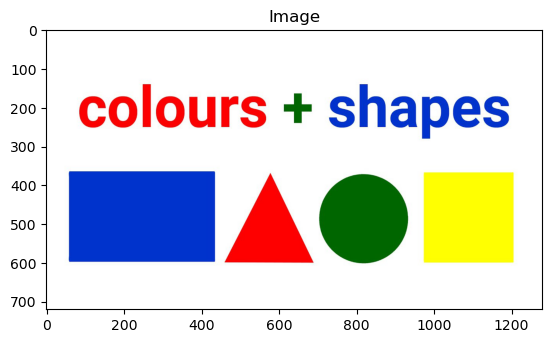

Image Max Value: 255 Image Min Value: 0


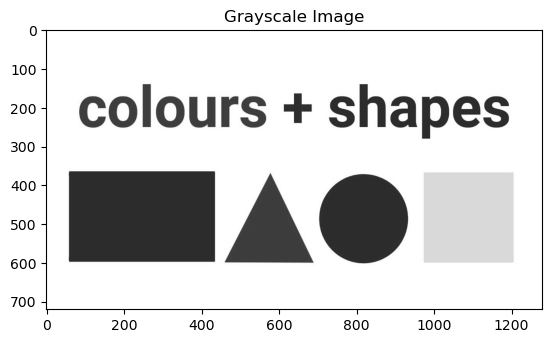

Image Max Value: 1050.6000000000001 Image Min Value: -1050.6000000000001
Image Max Value: 1050.5999999999997 Image Min Value: -1050.6000000000001
Image Max Value: 255.0 Image Min Value: 0.0
Image Max Value: 255.0 Image Min Value: 0.0


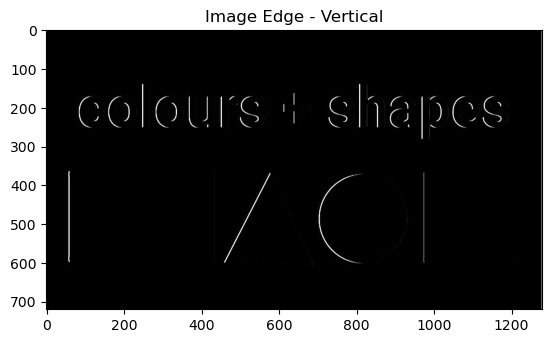

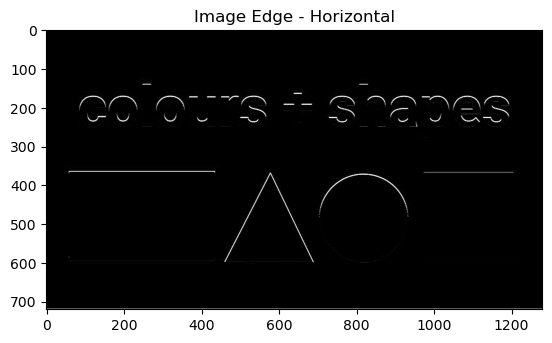

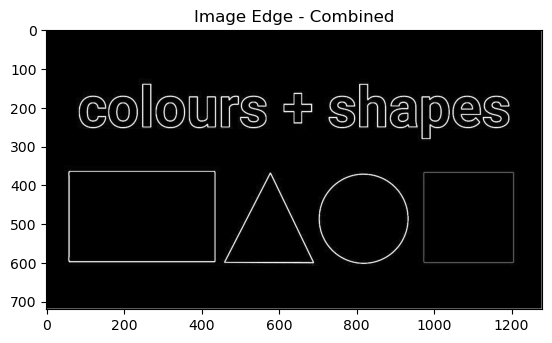

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg

from PIL import Image
import requests

#load image from the internet
url = 'https://i.ytimg.com/vi/BqKXHIRwGbs/maxresdefault.jpg'
resp = requests.get(url, stream=True).raw
img = Image.open(resp)

#ensure image is np.array
img = np.array(img)

#plot original image
plt.title("Image")
plt.imshow(img)
plt.show()

#increase data precision
img = img.astype(np.int16)
print('Image Max Value:', np.amax(img), 'Image Min Value:', np.amin(img))

#convert from colour to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

img_gray = rgb2gray(img)

#plot grayscale image
plt.title("Grayscale Image")
plt.imshow(img_gray, cmap='gray')
plt.show()

#two kernels
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]])

#perform 2d convolution
img_edge_x = sg.convolve(img_gray, sobel_x, mode='same')
img_edge_y = sg.convolve(img_gray, sobel_y, mode='same')

print('Image Max Value:', np.amax(img_edge_x), 'Image Min Value:', np.amin(img_edge_x))
print('Image Max Value:', np.amax(img_edge_y), 'Image Min Value:', np.amin(img_edge_y))

#combine images
img_edge = (img_edge_x**2 + img_edge_y**2)**.5

#normalize images
img_edge_x[img_edge_x > 255] = 255
img_edge_x[img_edge_x < 0] = 0

img_edge_y[img_edge_y > 255] = 255
img_edge_y[img_edge_y < 0] = 0

img_edge[img_edge > 255] = 255
img_edge[img_edge < 0] = 0


print('Image Max Value:', np.amax(img_edge_x), 'Image Min Value:', np.amin(img_edge_x))
print('Image Max Value:', np.amax(img_edge_y), 'Image Min Value:', np.amin(img_edge_y))

#return to image format
img_edge_x = img_edge_x.astype(np.uint8)
img_edge_y = img_edge_y.astype(np.uint8)
img_edge = img_edge.astype(np.uint8)

#plot results of convolution in x, and y
plt.title("Image Edge - Vertical")
plt.imshow(img_edge_x, cmap='gray')
plt.show()

plt.title("Image Edge - Horizontal")
plt.imshow(img_edge_y, cmap='gray')
plt.show()

plt.title("Image Edge - Combined")
plt.imshow(img_edge, cmap='gray')
plt.show()


## From MLP to CNN
In the example below you'll see that to go from an MLP to a CNN we only need to make a few changes to our architecture. The rest of the code remains the same.

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(1) # set the random seed

# obtain data
from torchvision import datasets, transforms

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:4096]
mnist_val   = mnist_data[4096:5120]

### MLP and CNN Architectures
Provided is sample code showing the differences between a simple ANN (MLP) and CNN architectures. Notice that the CNN architecture also contains fully connected layers.

In [28]:
#variable that allows you to toggle between MLP and CNN architectures
#True => CNN, False => ANN/MLP
select_CNN = True

if not select_CNN:

  #Artificial Neural Network Architecture (aka MLP)
  class MNISTClassifier(nn.Module):
      def __init__(self):
          super(MNISTClassifier, self).__init__()
          self.fc1 = nn.Linear(28 * 28, 50)
          self.fc2 = nn.Linear(50, 20)
          self.fc3 = nn.Linear(20, 10)

      def forward(self, img):
          flattened = img.view(-1, 28 * 28)
          activation1 = F.relu(self.fc1(flattened))
          activation2 = F.relu(self.fc2(activation1))
          output = self.fc3(activation2)
          return output

      print('Artificial Neural Network Architecture (aka MLP) Selected')
else:

  #Convolutional Neural Network Architecture
  class MNISTClassifier(nn.Module):
      def __init__(self):
          super(MNISTClassifier, self).__init__()
          self.conv1 = nn.Conv2d(1, 5, 5) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
          self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(160, 32)
          self.fc2 = nn.Linear(32, 10)

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 160)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

      print('Convolutional Neural Network Architecture Selected')

Convolutional Neural Network Architecture Selected


In [ ]:
def get_accuracy(model, train=False):
    if train:
        data = mnist_train
    else:
        data = mnist_val

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64, pin_memory=True):

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, pin_memory=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Comparing MLPs and CNNs

In [15]:
model = MNISTClassifier()

#proper model
train(model, mnist_train, num_epochs=5)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

With 5 epochs selected it can take several minutes to train the network. With the power of GPUs we can greatly reduce the time required and put that to tune our hyperparameters to acheive better results.

## Enable GPU
PyTorch allows you to run the computations on a GPU to speed up the processing. In order to enable GPUs you will need to:
1. select GPUs in "Notebook Settings" found under the "Edit" menu option.
2. setup model to work with the cuda
3. make sure image and labels data are stored placed on the GPU

An example of this is provided below.

In [29]:
def get_accuracy(model, train=False):
    if train:
        data = mnist_train
    else:
        data = mnist_val

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64, pin_memory=True):


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################


        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total


In [30]:
def train(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, pin_memory=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


CUDA is available!  Training on GPU ...


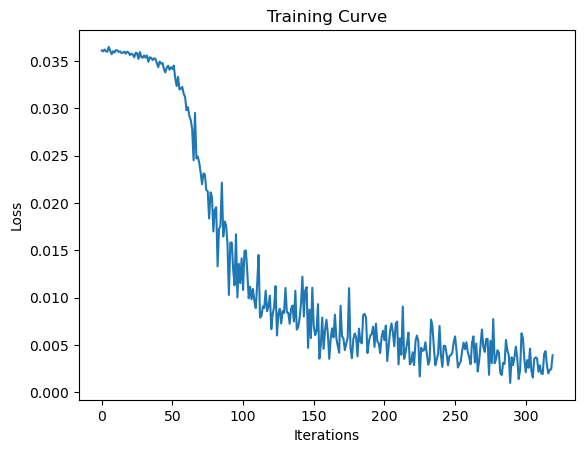

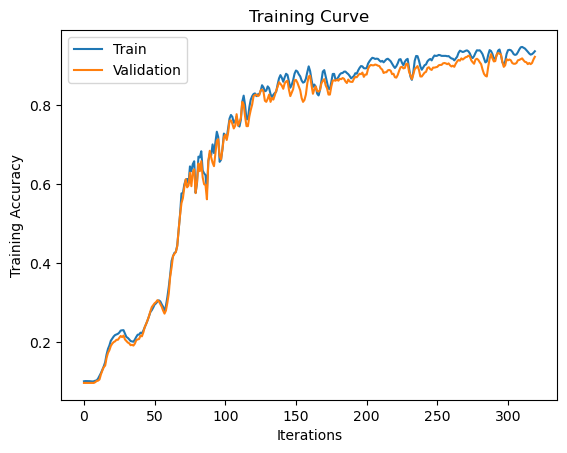

Final Training Accuracy: 0.93701171875
Final Validation Accuracy: 0.9228515625


In [ ]:
use_cuda = True

model = MNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train(model, mnist_train, num_epochs=10)

## Visualize Kernels

Recall what our convolution layer looks like:

*self.conv1 = nn.Conv2d(1, 5, 5) #in_channels, out_chanels, kernel_size*

There are 5 out channels => 5 kernels, kernel size = 5 and in_channels = 1, hence we're using 5 x 5 kernels.

In [ ]:
import matplotlib.pyplot as plt

# Visualize conv1 kernels (i.e filter)
kernels = model.conv1.weight.detach()

print(kernels.shape)


torch.Size([5, 1, 5, 5])


We can also plot the kernels:

tensor([[-0.0073,  0.0430, -0.0606, -0.1636,  0.1664],
        [ 0.0838, -0.1007, -0.0695, -0.1766,  0.0489],
        [-0.1735, -0.0597, -0.1501, -0.1554, -0.0640],
        [ 0.1226,  0.2140,  0.1465,  0.0414, -0.0232],
        [ 0.1149,  0.0405, -0.1154, -0.1316,  0.0680]])


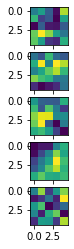

In [ ]:
#this line is required if using GPU
kernels = kernels.cpu()

#display first kernel
print(kernels[0][0])

#display all five kernels of dimension 5 x 5
fig, axarr = plt.subplots(kernels.size(0))
for idx in range(kernels.size(0)):
    axarr[idx].imshow(kernels[idx][0])

### Visualize Feature Map
We can also apply our kernel to our images to see what kind of features it extracts. In the example we will use a new image, but we could also apply this to one of the images in our training or validation data sets.

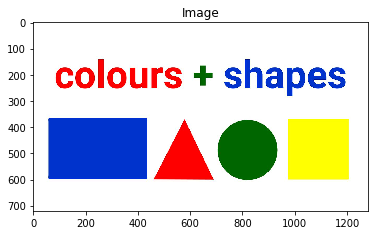

Image Max Value: 255 Image Min Value: 0


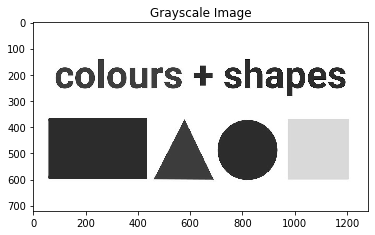

Image Max Value: 1033.5844682930601 Image Min Value: 158.8609126142422
Image Max Value: 255.0 Image Min Value: 158.8609126142422


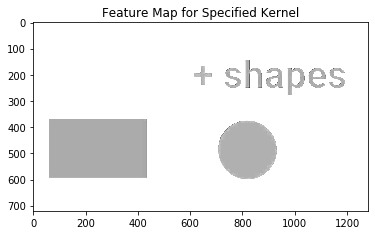

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg

from PIL import Image
import requests

#load image from the internet
url = 'https://i.ytimg.com/vi/BqKXHIRwGbs/maxresdefault.jpg'
resp = requests.get(url, stream=True).raw
img = Image.open(resp)

#ensure image is np.array
img = np.array(img)

#plot original image
plt.title("Image")
plt.imshow(img)
plt.show()

#increase data precision
img = img.astype(np.int16)
print('Image Max Value:', np.amax(img), 'Image Min Value:', np.amin(img))

#convert from colour to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

img_gray = rgb2gray(img)

#plot grayscale image
plt.title("Grayscale Image")
plt.imshow(img_gray, cmap='gray')
plt.show()

#select kernel
k = kernels[2][0]

#perform 2d convolution
img_k = sg.convolve(img_gray, k, mode='same')

print('Image Max Value:', np.amax(img_k), 'Image Min Value:', np.amin(img_k))

#normalize images
img_k[img_k > 255] = 255
img_k[img_k < 0] = 0

print('Image Max Value:', np.amax(img_k), 'Image Min Value:', np.amin(img_k))

#return to image format
img_k = img_k.astype(np.uint8)

#plot results of convolution
plt.title("Feature Map for Specified Kernel")
plt.imshow(img_k, cmap='gray')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

x = torch.randn(20, 3, 10, 10) # NCHW
conv = nn.Conv2d(in_channels=3, out_channels=7, kernel_size=5, padding=0)
print(conv(x).shape)


torch.Size([20, 7, 6, 6])


In [ ]:

pool = nn.MaxPool2d(kernel_size=2, stride=1)
print(pool(x).shape)

torch.Size([20, 3, 9, 9])
